
### Experiment 6: Training Schedule ##
**Initial Base-Line Run: (With imbalanced data of 159 (Apples), 140 (Oranges), 200 Bananas (Mixed), and 200 (Mixed) images)** 

In [14]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define transforms for the training dataset
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

# Load the training dataset from the correct path
train_data = ImageFolder(root='./train', transform=transform)

# Confirm dataset is loaded
print(f"Loaded {len(train_data)} training images from {train_data.root}")
print("Class-to-index mapping:", train_data.class_to_idx)


Loaded 699 training images from ./train
Class-to-index mapping: {'apple': 0, 'banana': 1, 'mixed': 2, 'orange': 3}


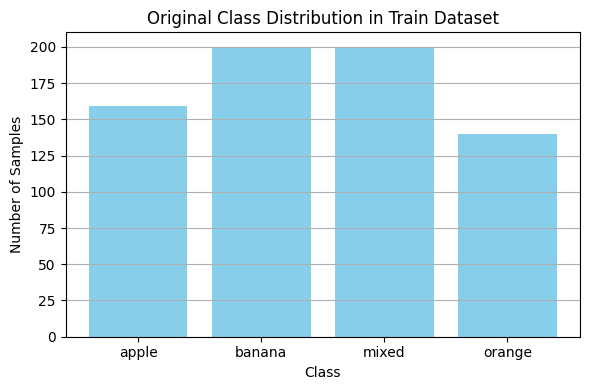

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

# Count how many samples there are per class
targets = train_data.targets  # List of labels for each image
class_counts = Counter(targets)

# Map indices to class names
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
class_names = [idx_to_class[i] for i in class_counts.keys()]
class_values = [class_counts[i] for i in class_counts.keys()]

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_names, class_values, color='skyblue')
plt.title("Original Class Distribution in Train Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


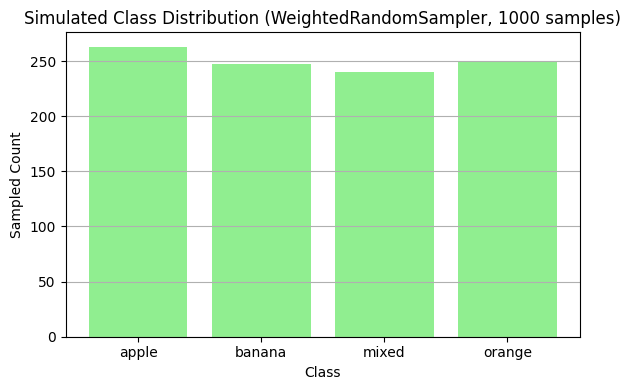

In [32]:
from torch.utils.data import WeightedRandomSampler
import random

# Simulate 1000 samples using train_sample_weights
simulated_sampler = WeightedRandomSampler(train_sample_weights, num_samples=1000, replacement=True)
sampled_indices = list(simulated_sampler)

# Map sampled indices to real labels from train_dataset
# train_dataset is a Subset of train_data
sampled_labels = [train_data.targets[train_dataset.indices[i]] for i in sampled_indices]

# Count sampled labels
sampled_counts = Counter(sampled_labels)

# Ensure all class indices show up
all_class_indices = list(idx_to_class.keys())
sampled_counts_complete = {i: sampled_counts.get(i, 0) for i in all_class_indices}

# Plot
sampled_class_names = [idx_to_class[i] for i in all_class_indices]
sampled_values = [sampled_counts_complete[i] for i in all_class_indices]

plt.figure(figsize=(6, 4))
plt.bar(sampled_class_names, sampled_values, color='lightgreen')
plt.title("Simulated Class Distribution (WeightedRandomSampler, 1000 samples)")
plt.xlabel("Class")
plt.ylabel("Sampled Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [9]:

from collections import Counter
from torch.utils.data import WeightedRandomSampler, Subset

# Count class distribution
targets = train_data.targets
class_counts = Counter(targets)

# Compute class weights (inverse of frequency)
num_samples = len(train_data)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}

# Assign a weight to each sample
sample_weights = [class_weights[label] for label in targets]

# Split into train/val indices
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size
train_indices, val_indices = torch.utils.data.random_split(
    range(len(train_data)), [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# Create subsets
train_dataset = Subset(train_data, train_indices)
val_dataset = Subset(train_data, val_indices)

# Apply WeightedRandomSampler on training set
train_sample_weights = [sample_weights[i] for i in train_indices]
train_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_indices), replacement=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



### Tuned Run #1:
**Epoch=15 to Epoch=30**


Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, Train Loss: 21.2981, Train Acc: 0.4029, Val Loss: 8.0042, Val Acc: 0.5667
Epoch 2, Train Loss: 16.6855, Train Acc: 0.5665, Val Loss: 6.6797, Val Acc: 0.6810
Epoch 3, Train Loss: 12.8007, Train Acc: 0.6973, Val Loss: 5.1344, Val Acc: 0.7048
Epoch 4, Train Loss: 9.7275, Train Acc: 0.7587, Val Loss: 5.4509, Val Acc: 0.7429
Epoch 5, Train Loss: 9.8794, Train Acc: 0.7771, Val Loss: 4.2255, Val Acc: 0.7762
Epoch 6, Train Loss: 7.7432, Train Acc: 0.8078, Val Loss: 3.7954, Val Acc: 0.8190
Epoch 7, Train Loss: 7.3725, Train Acc: 0.8384, Val Loss: 5.1820, Val Acc: 0.7381
Epoch 8, Train Loss: 7.7156, Train Acc: 0.8221, Val Loss: 3.8560, Val Acc: 0.8286
Epoch 9, Train Loss: 6.7351, Train Acc: 0.8364, Val Loss: 4.2513, Val Acc: 0.7857
Epoch 10, Train Loss: 5.9809, Train Acc: 0.8691, Val Loss: 4.9861, Val Acc: 0.8190
Epoch 11, Train Loss: 6.4828, Train Acc: 0.8528, Val Loss: 3.8859, Val Acc: 0.8048
Epoch 12, Train Loss: 5.567

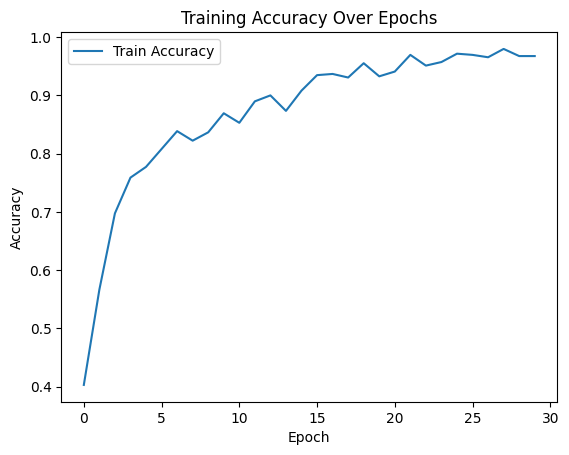

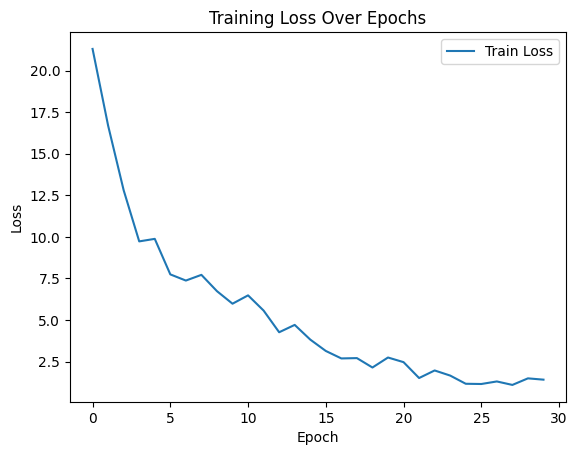

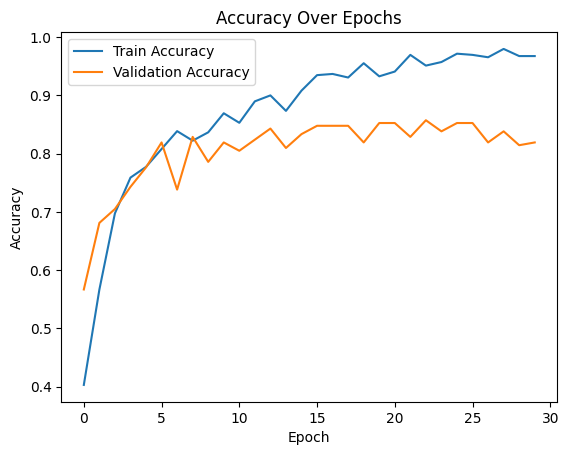

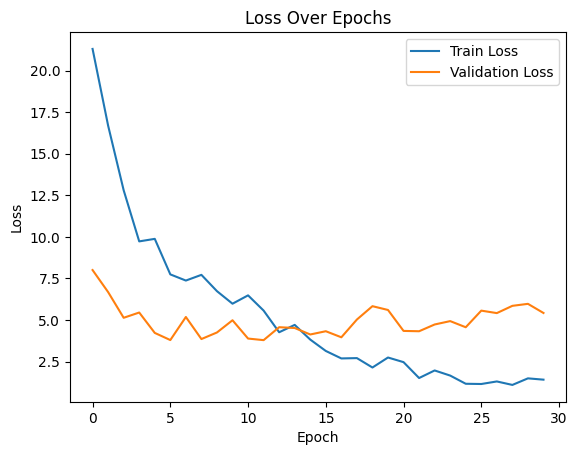

In [2]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split

# Define paths to your local training and testing image directories
train_path = "./train"
test_path = "./test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 30

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)


    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
          f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Tuned Run #2:
**Epoch=30 with Learning Rate Scheduler**


Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, LR: 0.001000, Train Loss: 20.4636, Train Acc: 0.4857, Val Loss: 9.2326, Val Acc: 0.4667
Epoch 2, LR: 0.001000, Train Loss: 15.0077, Train Acc: 0.6286, Val Loss: 5.8054, Val Acc: 0.7833
Epoch 3, LR: 0.001000, Train Loss: 11.4451, Train Acc: 0.7893, Val Loss: 5.1649, Val Acc: 0.7833
Epoch 4, LR: 0.001000, Train Loss: 9.4625, Train Acc: 0.8250, Val Loss: 4.7048, Val Acc: 0.7750
Epoch 5, LR: 0.001000, Train Loss: 8.5292, Train Acc: 0.8321, Val Loss: 4.2927, Val Acc: 0.8167
Epoch 6, LR: 0.001000, Train Loss: 8.2816, Train Acc: 0.8321, Val Loss: 4.6154, Val Acc: 0.8083
Epoch 7, LR: 0.001000, Train Loss: 6.0144, Train Acc: 0.8911, Val Loss: 4.0741, Val Acc: 0.8500
Epoch 8, LR: 0.001000, Train Loss: 6.2158, Train Acc: 0.8804, Val Loss: 4.8406, Val Acc: 0.8042
Epoch 9, LR: 0.001000, Train Loss: 6.9990, Train Acc: 0.8625, Val Loss: 3.5439, Val Acc: 0.8250
Epoch 10, LR: 0.001000, Train Loss: 5.0612, Train Acc: 0.9107, Val 

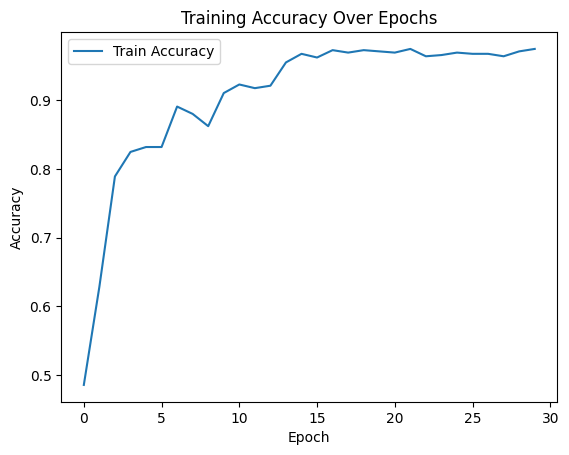

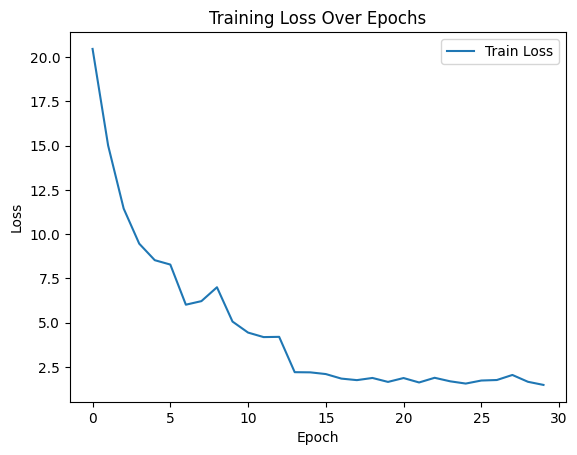

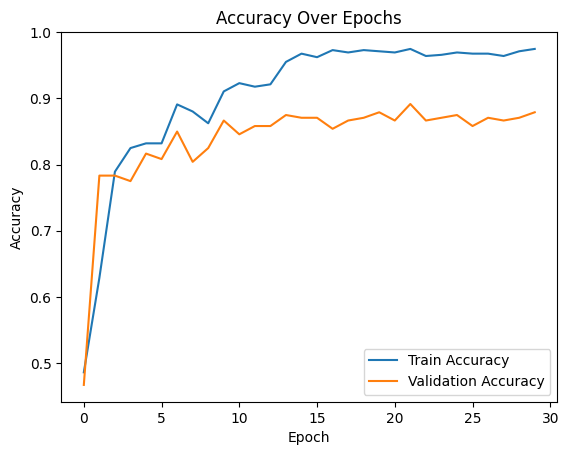

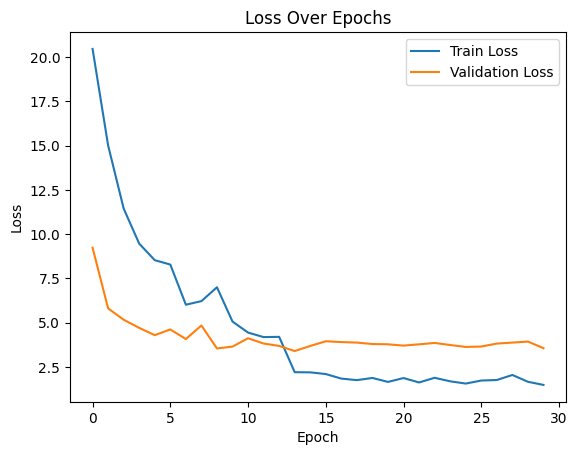

In [ ]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

#Adding in scheduler, once after 3 runs of epoch and it plateau, to start reducing LR by x0.1 with a minimum of 1e-6
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 3, min_lr=1e-6)

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 30

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)

    scheduler.step(val_running_loss)

    current_lr = optimizer.param_groups[0]['lr']
    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, LR: {current_lr:.6f}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
      f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Tuned Run #3:
**Epoch=50 with Learning Rate Scheduler**


Classes: ['apple', 'banana', 'mixed', 'orange']
Using device: mps
Epoch 1, LR: 0.001000, Train Loss: 21.3164, Train Acc: 0.4714, Val Loss: 7.0117, Val Acc: 0.7000
Epoch 2, LR: 0.001000, Train Loss: 13.9533, Train Acc: 0.7054, Val Loss: 5.9397, Val Acc: 0.7417
Epoch 3, LR: 0.001000, Train Loss: 12.4557, Train Acc: 0.7357, Val Loss: 4.5111, Val Acc: 0.7792
Epoch 4, LR: 0.001000, Train Loss: 10.0362, Train Acc: 0.7946, Val Loss: 3.9895, Val Acc: 0.8625
Epoch 5, LR: 0.001000, Train Loss: 9.1213, Train Acc: 0.8196, Val Loss: 4.5123, Val Acc: 0.8458
Epoch 6, LR: 0.001000, Train Loss: 8.2578, Train Acc: 0.8393, Val Loss: 3.3629, Val Acc: 0.8625
Epoch 7, LR: 0.001000, Train Loss: 6.9797, Train Acc: 0.8518, Val Loss: 3.0647, Val Acc: 0.8792
Epoch 8, LR: 0.001000, Train Loss: 5.9007, Train Acc: 0.8714, Val Loss: 2.9765, Val Acc: 0.8875
Epoch 9, LR: 0.001000, Train Loss: 6.8312, Train Acc: 0.8607, Val Loss: 2.8687, Val Acc: 0.8875
Epoch 10, LR: 0.001000, Train Loss: 5.2455, Train Acc: 0.8946, Val

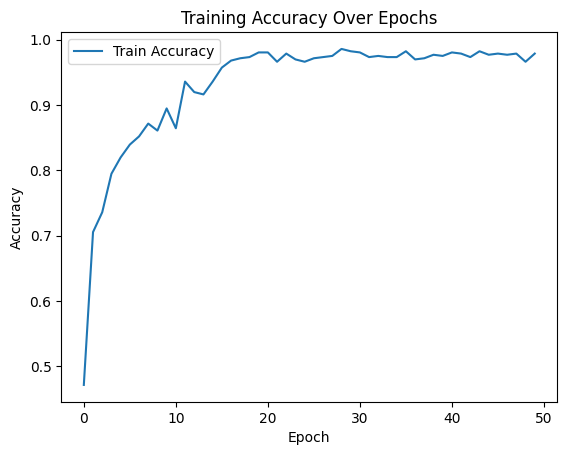

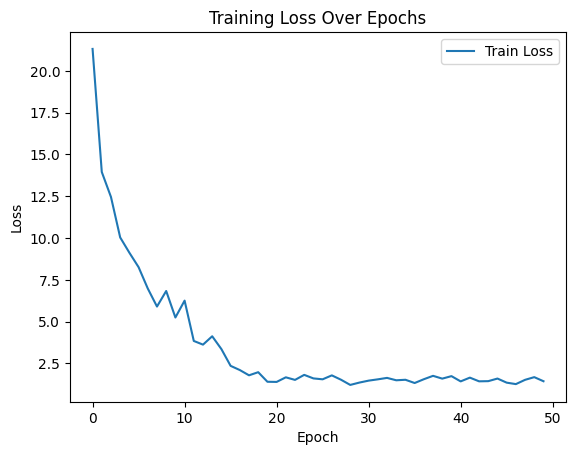

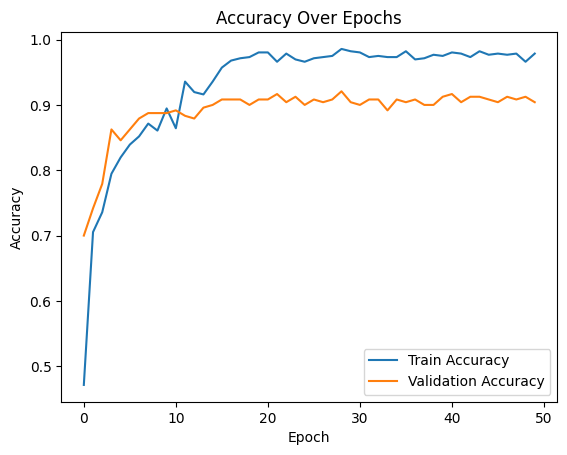

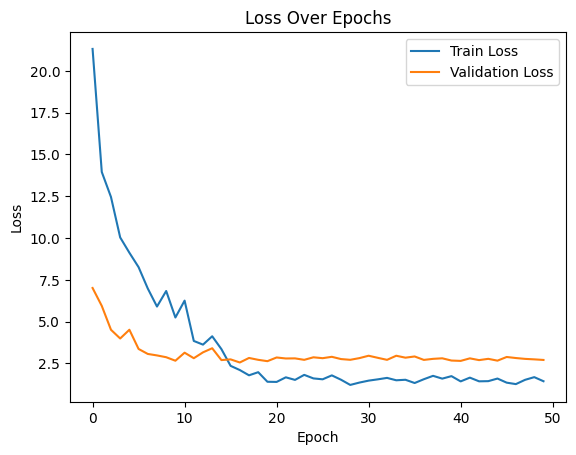

In [ ]:
# Import required libraries for data handling, model building, and visualization
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define paths to your local training and testing image directories
train_path = "../train"
test_path = "../test"

# Define image transformations for training data
transform_train = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.RandomHorizontalFlip(),        # Randomly flip images horizontally for augmentation
    transforms.RandomRotation(15),            # Randomly rotate images by up to ±15 degrees
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values to range [-1, 1]
])

# Define transformations for test data (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((100, 100)),            # Resize images to 100x100
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize pixel values
])


# Load training and test datasets using folder structure
train_data = ImageFolder(train_path, transform=transform_train)
test_data = ImageFolder(test_path, transform=transform_test)

#For validation, splitting training by 70% and validation by 30%
train_size = int(0.7 * len(train_data))
val_size = len(train_data) - train_size

train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Print class labels detected from folder names
print("Classes:", train_data.classes)

# Define the CNN architecture
class FruitCNN(nn.Module):
    def __init__(self):
        super(FruitCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer
            nn.ReLU(),                                  # ReLU activation
            nn.MaxPool2d(2),                             # Max pooling to reduce spatial size

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Third convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),                                # Flatten the output to 1D
            nn.Linear(128 * 12 * 12, 256),                # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),                              # Dropout for regularization
            nn.Linear(256, 4)                             # Output layer for 4 fruit classes
        )

    def forward(self, x):
        return self.model(x)  # Define forward pass

# Use GPU if available, otherwise fallback to CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Initialize model, define loss function and optimizer
model = FruitCNN().to(device)
criterion = nn.CrossEntropyLoss()                # Use cross entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

#Adding in scheduler, once after 3 runs of epoch and it plateau, to start reducing LR by x0.1 with a minimum of 1e-6
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience = 3, min_lr=1e-6)

# Lists to track training accuracy and loss
train_acc = []
train_loss = []
val_acc = []
val_loss = []

# Set number of epochs
epochs = 50

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    correct = 0
    total = 0
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device

        optimizer.zero_grad()          # Clear previous gradients
        outputs = model(images)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backward pass
        optimizer.step()               # Update weights

        running_loss += loss.item()    # Accumulate loss
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)        # Total samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    acc = correct / total             # Calculate accuracy
    train_loss.append(running_loss)   # Record loss
    train_acc.append(acc)             # Record accuracy

    #Validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss_batch = criterion(val_outputs, val_labels)
            val_running_loss += val_loss_batch.item()
            _, val_preds = torch.max(val_outputs,1)
            val_total += val_labels.size(0)
            val_correct += (val_preds == val_labels).sum().item()

    epoch_val_acc = val_correct/val_total
    val_acc.append(epoch_val_acc)
    val_loss.append(val_running_loss)

    scheduler.step(val_running_loss)

    current_lr = optimizer.param_groups[0]['lr']
    # Print metrics after each epoch
    print(f"Epoch {epoch+1}, LR: {current_lr:.6f}, Train Loss: {running_loss:.4f}, Train Acc: {acc:.4f}, "
      f"Val Loss: {val_running_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

# Evaluation on test set
model.eval()  # Set model to evaluation mode
y_true = []
y_pred = []

# No need to calculate gradients during evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted classes
        y_pred.extend(preds.cpu().numpy())  # Store predictions
        y_true.extend(labels.numpy())       # Store actual labels

# Print classification report
print(classification_report(y_true, y_pred, target_names=train_data.classes))

# Plot training accuracy over epochs
plt.plot(train_acc, label='Train Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss over epochs
plt.plot(train_loss, label='Train Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
